In [1]:
library(tidyverse)
library(tidymodels)
library(dplyr)
library(lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Individual Planning Report

**(1) Data Description**

The players.csv dataset has many variables about what types of people are playing Plaicraft. There are 196 observations in total, since there are 197 rows, but the first row includes the column names. The different variables include:

* experience (experience level of player)
* subscribe (whether the player subscribed to the newsletter)
* hashedEmail (encrypted email)
* played_hours (number of hours played by the player)
* gender (chr - male, female etc) *age (players age).

The last two variables do not have any data under them. These present issues in the data because when read in Jupyter, it will show up as "NA" for those columns.

For sessions.csv, there are 1535 rows of observations with 5 variables:

* hashedEmail (same as players.csv)
* start_time (date + time of starting a session)
* end_time (date + time of ending a session)
* original_start_time (computer way of telling time, in seconds)
* original_end_time (computer way of telling time, in seconds)

start_time and end_time present issues because the data is not tidy.

**(2) Question**

Can we predict the persons experience level from how long they've played in this server?

Use the exerience column from players.csv and separate the start_time and end_time into their respective dates and times to be able to subtract times. Use group_by() and summarize() to add up the times for each hashedEmail and use that as the explanatory variable. Also use played_hours as another explanatory variable to predict experience. Will need to combine the two datasets using hashedEmail as the common variable.

**(3) Exploratory Data Analysis and Visualization**

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,hashedEmail,experience,subscribe,played_hours,gender,age,start_time,end_time,original_start_time,original_end_time
,<chr>,<chr>,<lgl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Male,20,23/05/2024 00:22,23/05/2024 01:07,1.71642e+12,1.71643e+12
2,0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,Regular,TRUE,1.5,Male,20,22/05/2024 23:12,23/05/2024 00:13,1.71642e+12,1.71642e+12
3,060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,Pro,FALSE,0.4,Male,21,28/06/2024 04:28,28/06/2024 04:58,1.71955e+12,1.71955e+12
4,0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,Beginner,TRUE,0.1,Male,17,19/09/2024 21:01,19/09/2024 21:12,1.72678e+12,1.72678e+12
5,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,TRUE,5.6,Male,17,30/08/2024 03:40,30/08/2024 04:04,1.72499e+12,1.72499e+12
6,0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,Regular,TRUE,5.6,Male,17,27/08/2024 19:18,27/08/2024 19:52,1.72479e+12,1.72479e+12


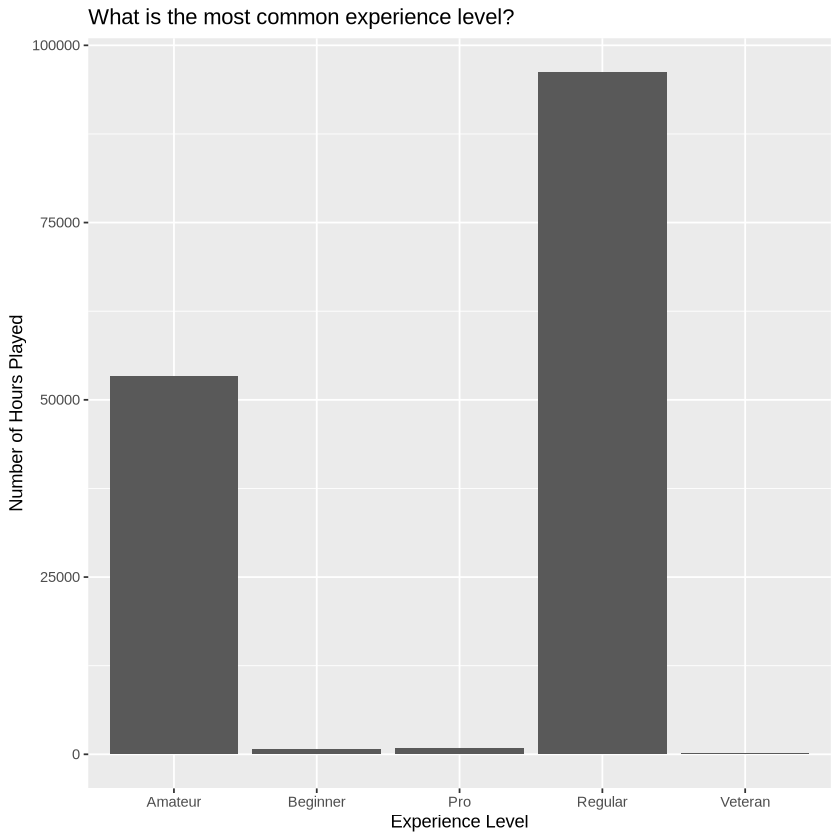

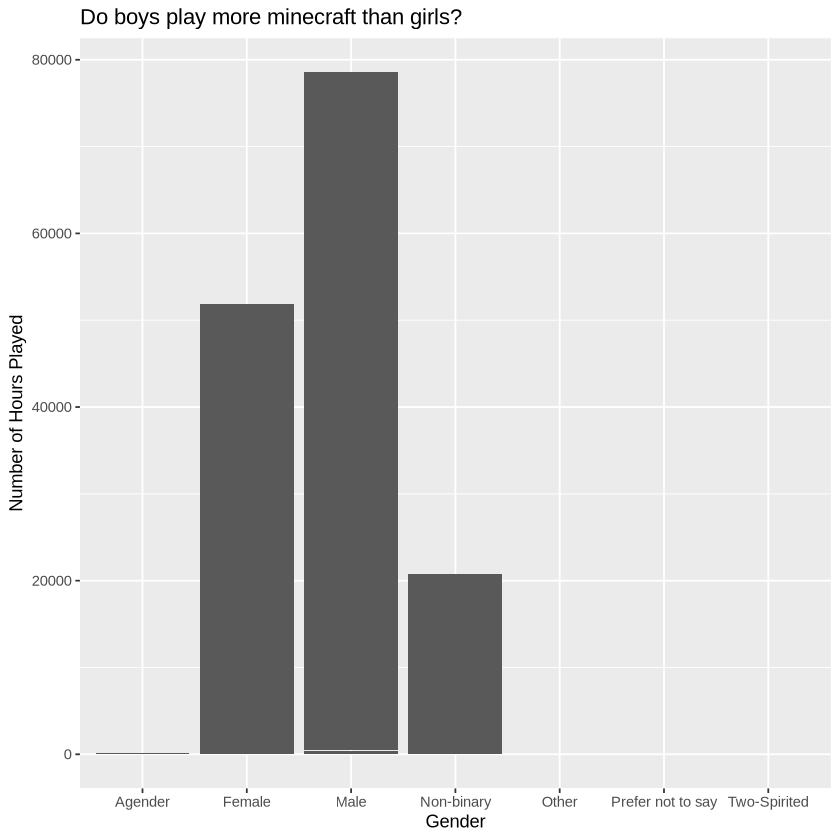

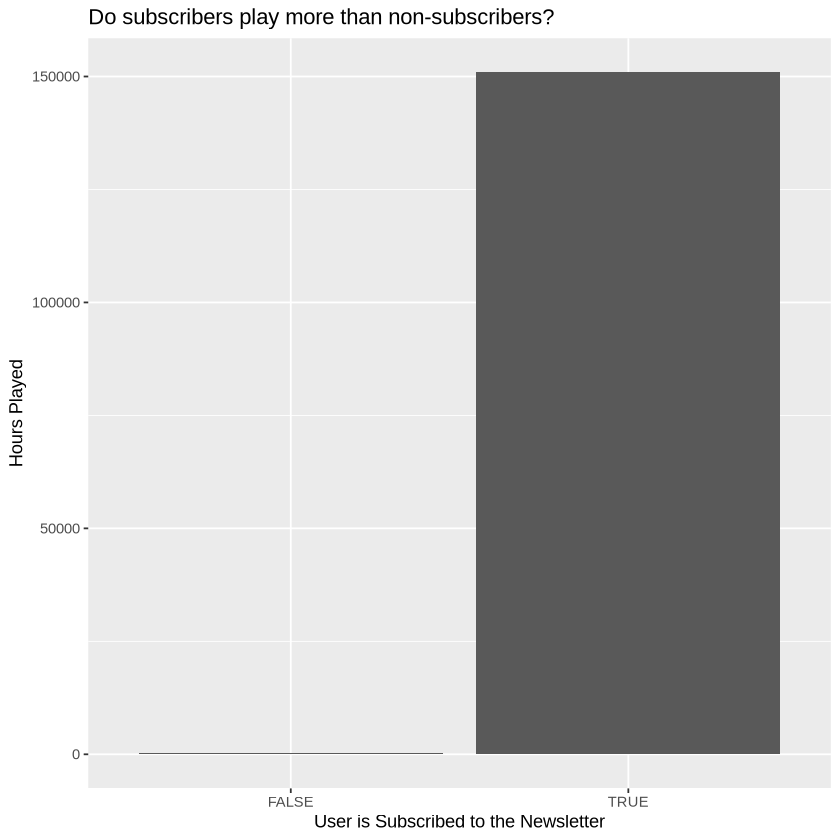

In [37]:
url_players <- "https://raw.githubusercontent.com/Tytayneum/dsci100_project_sefa/refs/heads/main/players.csv"
url_sessions <- "https://raw.githubusercontent.com/Tytayneum/dsci100_project_sefa/refs/heads/main/sessions.csv"

players_raw <- read_csv(url_players)

sessions_raw <- read_csv(url_sessions)

merged_data <- merge(players_raw, sessions_raw, by = "hashedEmail", all = TRUE) |>
    select(-individualId, -organizationName, -name) |>
    filter(start_time != "NA")

head(merged_data)

played_hours_vs_experience <- merged_data |>
    ggplot(aes(x = experience, y = played_hours)) +
    geom_bar(stat = "identity") +
    labs(x = "Experience Level", y = "Number of Hours Played", title = "What is the most common experience level?")
played_hours_vs_experience #Regular is the most popular

played_hours_vs_gender <- merged_data |>
    ggplot(aes(x = gender, y = played_hours)) +
    geom_bar(stat = "identity") +
    labs(x = "Gender", y = "Number of Hours Played", title = "Do boys play more minecraft than girls?")
played_hours_vs_gender # males play more

subscribed <- merged_data |>
    ggplot(aes(x = subscribe, y = played_hours)) +
    geom_bar(stat = "identity") +
    labs(x = "User is Subscribed to the Newsletter", y = "Hours Played", title = "Do subscribers play more than non-subscribers?")
subscribed #subscribers play more

**(4) Methods and Plan**

Combine the two datasets together using hashedEmail as the common variable. Then, find the total time played in minutes for each session by subtracting the end_time from the start_time. (Will need to separate the date and time into two separate columns to do this.) Then, will group_by( ) the hashedEmails and summarize( ) using their total time played. Now, we have 3 variables: experience level, hashedEmail, and total_time. Using knn-classification, we will attempt to predict a user's experience level from their total_time by splitting the data randomly into 75% training and 25% testing and using neighbors = tune( ) neighbours to try neighbours from 1 to 100. Assumptions being made is that users with a higher experience level will have a higher total_time played. After splitting the data, it will be trained with knn-classification and tested on the testing set to predict the experience level. A 5-fold cross-validation will later be conducted as well to test the accuracy.